In [1]:
#%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
import scipy.stats
from scipy import interpolate
from scipy.interpolate import griddata

In [3]:
def array_sort(x):
    for i in range(len(x[0])):
        swap = i + np.argmin(x[0][i:])
        for j in range(len(x)):
            (x[j][i], x[j][swap]) = (x[j][swap], x[j][i])
    return x

# 1. Pesos en la función de correlación (estimador de Landy-Salay)

# a) Construye dos anillos concéntricos de radios distintos y ancho fijo, pero que el radio mayor del anillo más pequeño sea igual al radio menor del anillo más grande (ie ambos anillos deben de verse como un solo anillo del doble de ancho). La densidad de ambos anillos debe de ser igual. Grafica la distribución poniendo color rojo a los puntos del anillo pequeño y azul a los del grande.

In [5]:
# Anillos

L = 1000 #tamaño de la caja
r1 = 200 #radio base
dr = 50
r2 = r1 + dr
r3 = r2 + dr
ro = 0.01

vol_an1 = (r2**2 - r1**2) * np.pi
vol_an2 = (r3**2 - r2**2) * np.pi

n1 = round(vol_an1 * ro)
n2 = round(vol_an2 * ro)
n = n1 + n2
#n

In [6]:
theta_an1 = 2 * np.pi * np.random.rand(n1)
theta_an2 = 2 * np.pi * np.random.rand(n2)
theta_an1.sort()
theta_an2.sort()

R1 = r1 + np.random.rand(n1) * dr #radios aleatorios
R2 = r2 + np.random.rand(n2) * dr #radios aleatorios

#coordenadas de los anillos
an1x = R1 * np.cos( theta_an1 )
an1y = R1 * np.sin( theta_an1 )

an2x = R2 * np.cos( theta_an2 )
an2y = R2 * np.sin( theta_an2 )

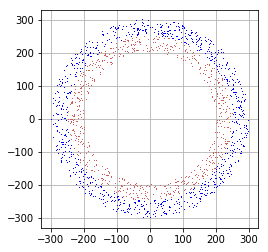

In [7]:
plt.plot(an1x, an1y,',',color='indianred')
plt.plot(an2x, an2y,',',color='b')
plt.axis('scaled')
plt.grid()

In [9]:
anillos_x = np.concatenate((an1x, an2x))
anillos_y = np.concatenate((an1y, an2y))

# b) Mide la función de correlación asignando los siguientes pesos a cada punto: para puntos en el anillo pequeño (rojos) usa un peso de 2, mientras que para puntos en el anillo grande (azules) usa 1/2. Sobrepon en una gráfica la función de correlación sin pesos con la de pesos, y describe las diferencias en palabras.

In [10]:
def DD_Pesos(sx,sy,w1,w2,n,n1,bins,rmax=100):
    
    dt = rmax/bins
    hist = np.zeros(bins)
    rango = np.arange(dt/2, rmax + (dt/2), dt)
    
    wi = w1
    wj = w1
    
    for i in range(n):
        if i >= n1:
            wi = w2
        wj = w1
        for j in range(i+1,n):
            dist = (( sx[i]-sx[j] )**2 + (sy[i]-sy[j])**2)**(1/2)
            where = int(round((dist/dt) + 0.5) - 1)
            if where < bins:
                if j >= n1:
                    wj = w2
                hist[where] = hist[where] + wi * wj
    norm = (n1*(n1-1)/2)*w1*w1 + ((n-n1)*((n-n1)-1)/2)*w2*w2 + (n1*(n-n1))*w1*w2 #n*(n-1)/2
    hist = hist/norm
    return rango, hist
#--------------------------------------------------------------------------------------------------

def DR_Pesos(sx,sy,w1,w2,wr,n,n1,bins,L,rmax=100):
    
    nd = len(sx)
    dt = rmax/bins
    hist = np.zeros(bins)
    
    np.random.seed(42)
    
    ran_x, ran_y = np.random.rand(2,n) * L
    rango = np.arange(dt/2,rmax+(dt/2),dt)
    wi = w1
    
    for i in range(nd):
        if i >= n1:
            wi = w2
        wj = w1
        for j in range(n):
            dist = (( sx[i]-ran_x[j] )**2 + (sy[i]-ran_y[j])**2)**(1/2)
            where = int(round((dist/dt) + 0.5) - 1)
            if where < bins:
                hist[where] = hist[where] + wi*wr
    norm = (n1*n)*w1*wr + ((n-n1)*n)*w2*wr   #nd*n
    hist = hist/norm
    return rango, hist #, ran_x, ran_y
#-------------------------------------------------------------------------------------------------------

def RR_Pesos(wr,L,bins,n,rmax=100):
    
    dt = rmax/bins
    hist = np.zeros(bins)
    
    np.random.seed(42)
    
    samp_x, samp_y = np.random.rand(2,n) * L
    rango = np.arange(dt/2,rmax+(dt/2),dt)
    
    for i in range(n):
        for j in range(i+1,n):
            dist = (( samp_x[i]-samp_x[j] )**2 + (samp_y[i]-samp_y[j])**2)**(1/2)
            where = int(round((dist/dt) + 0.5) - 1)
            if where < bins:
                hist[where] = hist[where] + wr*wr
    norm = (n*(n-1)/2)*wr
    hist = hist/norm
    return rango, hist

In [17]:
def DD(samp_x,samp_y,bins,rmax=0):
    
    n = len(samp_x.flatten())
    dt = rmax/bins
    hist = np.zeros(bins)
    rango = np.arange(dt/2,rmax+(dt/2),dt)
    
    for i in range(n):
        for j in range(i+1,n):
            dist = (( samp_x[i]-samp_x[j] )**2 + (samp_y[i]-samp_y[j])**2)**(1/2)
            where = int(round((dist/dt) + 0.5) - 1)
            if where < bins:
                hist[where] = hist[where] + 1
    norm = n*(n-1)/2
    hist = hist/norm
    
    return rango, hist

#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------

def DR(samp_x,samp_y,L,bins,n,rmax=0):
    
    nd = len(samp_x)
    
    if rmax==0:
        rmax = L*(2**(1/2))
    dt = rmax/bins
    hist = np.zeros(bins)
    np.random.seed(42)
    ran_x, ran_y = np.random.rand(2,n) * L
    rango = np.arange(dt/2,rmax+(dt/2),dt)
    
    for i in range(nd):
        for j in range(n):
            dist = (( samp_x[i]-ran_x[j] )**2 + (samp_y[i]-ran_y[j])**2)**(1/2)
            where = int(round((dist/dt) + 0.5) - 1)
            if where < bins:
                hist[where] = hist[where] + 1
    norm = nd*n
    hist = hist/norm
    
    return rango, hist, ran_x, ran_y
#----------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------

def RR(L,bins,n,rmax=0):
    if rmax==0:
        rmax = L*(2**(1/2))
    dt = rmax/bins
    hist = np.zeros(bins)
    
    np.random.seed(42)
    
    samp_x, samp_y = np.random.rand(2,n) * L
    rango = np.arange(dt/2,rmax+(dt/2),dt)
    
    for i in range(n):
        for j in range(i+1,n):
            dist = (( samp_x[i]-samp_x[j] )**2 + (samp_y[i]-samp_y[j])**2)**(1/2)
            where = int(round((dist/dt) + 0.5) - 1)
            if where < bins:
                hist[where] = hist[where] + 1
    norm = n*(n-1)/2
    hist = hist/norm
    
    return rango, hist

In [12]:
def Corr(sx,sy,L,bins,nr,rmax=0):
    np.random.seed(42)
    dd = DD(sx,sy,bins,rmax)
    dr = DR(sx,sy,L,bins,nr,rmax)
    rr = RR(L,bins,nr,rmax)
    rango = dd[0]
    return dd[1], dr[1], rr[1], rango

def CorrPesos(sx,sy,w1,w2,wr,n,n1,L,bins,rmax=100):
    np.random.seed(42)
    DD = DD_Pesos(sx,sy,w1,w2,n,n1,bins,rmax)
    DR = DR_Pesos(sx,sy,w1,w2,wr,n,n1,bins,L,rmax)
    RR = RR_Pesos(wr,L,bins,n,rmax)
    rango = DD[0]
    return DD[1], DR[1], RR[1], rango

In [15]:
rango, ddpesos = DD_Pesos(anillos_x, anillos_y, 0.5, 2, n, n1, 100, 650)

In [18]:
rango, dd = DD(anillos_x, anillos_y, 100, 650)

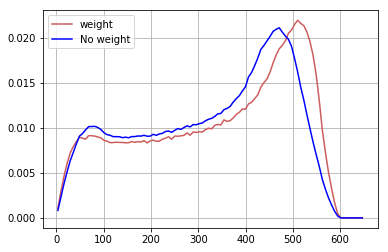

In [19]:
plt.plot(rango, ddpesos, color='indianred', label='weight')
plt.plot(rango, dd, color='b', label='No weight')
plt.legend()
plt.grid()

In [20]:
w1 = 2
w2 = 0.5
wr = 1
bins = 100
rmax = 650


In [22]:
ddpesos, drpesos, rrpesos, rango = CorrPesos(anillos_x,anillos_y,w1,w2,wr,n,n1,L,bins,rmax)

In [23]:
dd, dr, rr, rango = Corr(anillos_x,anillos_y,L,bins,n,rmax)

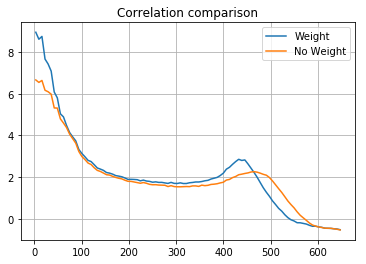

In [24]:
LS_Pesos = ((ddpesos - 2*drpesos + rrpesos)/rrpesos)
LS = ((dd - 2*dr + rr)/rr)
plt.plot(rango,LS_Pesos,label='Weight')
plt.plot(rango,LS,label='No Weight')
plt.title('Correlation comparison')
plt.legend()
plt.grid()

Al comparar las correlaciones podemos observar que utilizando pesos "crece" la correlación en distancias de 400 a 450, las cuales corresponden a ditancias entre dos puntos del anillo interior.